# MNIST Digit Recognition with a Convolutional Neural Network

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this notebook, a 5 layers Sequential Convolutional Neural Network (CNN) will be developed to correctly identify digits from a dataset of tens of thousands of handwritten images. The neural network will leverage the keras API and and TensorFlow backend.

In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter("ignore")

# Plotting Libraries
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
sns.set_palette(blues)
sns.set_style("whitegrid")

# Keras API
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator  # For Data Augmentation
from keras.callbacks import ReduceLROnPlateau

# TensorFlow Backend
import tensorflow as tf

# SciKit Learn Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Load, Explore, and Prepare Data for the CNN

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

> 000 001 002 003 ... 026 027<br>
> 028 029 030 031 ... 054 055<br>
> 056 057 058 059 ... 082 083<br>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;...&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|<br>
> 728 729 730 731 ... 754 755<br>
> 756 757 758 759 ... 782 783 <br>

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

In [47]:
# Load the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [54]:
# Check for null values in train and test data sets
print(train.isnull().any().describe())
print(test.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


There are no nulls in the training or test data so no additional data cleansing or filling for nulls is required. 

In [ ]:
# Peel the Target data (digit labels) from the Features Set (28x28 pixels) in the Training Data
y_train = train["label"]
x_train = train.drop(labels = ["label"],axis = 1) 

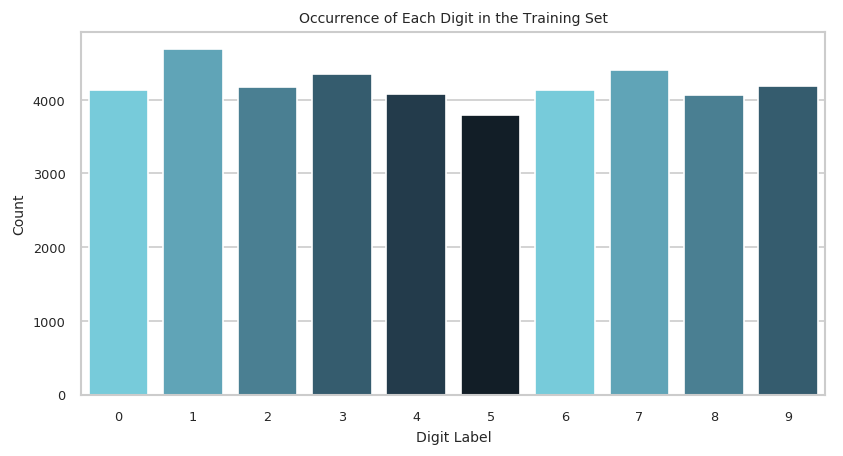

In [46]:
# Histogram the Occurence of each Class - Look for Unbalanced Classes
fig=plt.figure(figsize=(8, 4), dpi= 120, facecolor='w', edgecolor='k')
sns.set_style("whitegrid")
sns.countplot(y_train, palette=blues)
plt.title("Occurrence of Each Digit in the Training Set")
plt.ylabel("Count")
plt.xlabel("Digit Label")
plt.show()

The histogram reveals relatively balanced classes, almost uniform.
<br><br>
Now lets normalize the 255-bit pixel depth as this will improve model efficiency and avoids other potential issues.

In [5]:
# Normalize Grayscale Pixel Values by Max Pixel Depth
pixel_depth = 255.0
x_train = x_train / pixel_depth
test = test / pixel_depth

When loading each image into the train or test pandas data frame, the 28px by 28px images arew converted into one-dimensional vectors with a length of 784. The next step, reshapes the 784pixel vectors back into 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [55]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

There are ten labels, representing the numbers from 0 to 9. These labels need to be encoded to a vector (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]) that will correspond to the neural network's output node.

In [56]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

In [57]:
n_inputs = 28*28  # MNIST










In [9]:
# Split the train and the validation set for the fitting
random_seed = 2  # Fix the random seed for repeatability
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

!!!
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

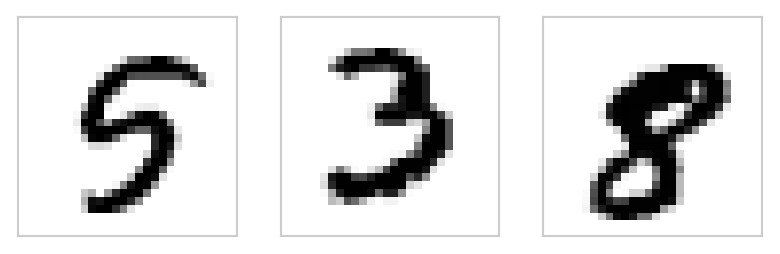

In [68]:
# Some examples
num_examples_to_plot = 3
fig, ax = plt.subplots(1,num_examples_to_plot, figsize=(8, 4), dpi= 120, facecolor='w', edgecolor='k')
for axl in range(0,num_examples_to_plot):
    ax[axl].imshow((x_train[axl+8][:,:,0]), cmap="gray_r")
    ax[axl].grid(False)
    ax[axl].set_yticks([])
    ax[axl].set_xticks([])
plt.show()

## The Convolutional Neural Network

### Defining the CNN Model


This approach uses the Keras Sequential API, where one layer is added at a time, starting from the input.

The first is the convolutional (Conv2D) layer which may be thought of as a set of learnable filters. For this project, the CNN uses 32 filters within the first two conv2D layers and 64 filters within the two last layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN isolates features that are useful everywhere from these transformed images (feature maps).

Another important layer in CNNs is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. The pooling size (the area pooled at each application) must be chosen. When the pooling dimension is high, downsampling is greater.

Combining convolutional and pooling layers, the CNN is able to learn and combine both local and global features of the images being processed.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (node weights set to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

This CNN implementation uses the 'ReLU' activation function. Rectified Linear Units is is the rectifier activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is required to take advantage of the fully connected layers after some convolutional/maxpool layers. It combines all the local features identified in previous convolutional layers.

!!! 

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.


PLACE ELSEWHERE

The evaluation metric for the related kaggle contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [21]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

W0630 16:26:54.313881 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 16:26:54.331380 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 16:26:54.335005 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 16:26:54.362500 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Pleas

### Setting the Optimizer and Annealer

!!! Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [22]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

W0630 16:28:32.895728 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 16:28:32.904536 140521748596544 deprecation_wrapper.py:119] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



!!! 
learningrates.jpg

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [24]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### Data Augmentation

!!!
In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :
<ul>
    <li>Without data augmentation i obtained an accuracy of 98.114%</li>
    <li>With data augmentation i achieved 99.67% of accuracy</li>
</ul>

In [26]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [27]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

!!!
For the data augmentation, i choosed to :
<ul>
    <li>Randomly rotate some training images by 10 degrees</li>
    <li>Randomly Zoom by 10% some training images</li>
    <li>Randomly shift images horizontally by 10% of the width</li>
    <li>Randomly shift images vertically by 10% of the height</li>
</ul>
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset.

In [28]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

W0630 16:44:50.805376 140521748596544 deprecation.py:323] From /home/jeffrey/Documents/anaconda/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
 - 44s - loss: 0.4323 - acc: 0.8618 - val_loss: 0.0513 - val_acc: 0.9843
Epoch 2/3
 - 43s - loss: 0.1286 - acc: 0.9614 - val_loss: 0.0555 - val_acc: 0.9848
Epoch 3/3
 - 42s - loss: 0.0944 - acc: 0.9717 - val_loss: 0.0272 - val_acc: 0.9912


### Training and Validation Curves

In [29]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [30]:
history.history['loss']

[0.4323480348686151, 0.12854504295631064, 0.09446010317997361]

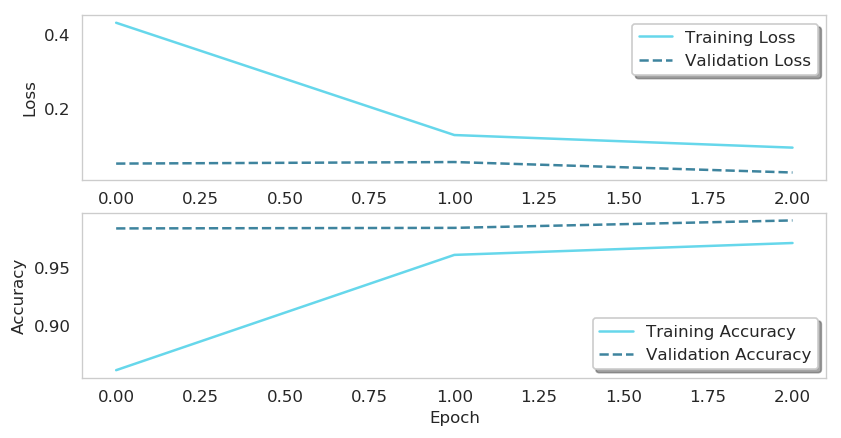

In [31]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(8, 4), dpi= 120, facecolor='w', edgecolor='k')

ax[0].plot(history.history['loss'], color=blues[0], label="Training Loss")
ax[0].plot(history.history['val_loss'], color=blues[2], linestyle="--", label="Validation Loss",axes =ax[0])
ax[0].grid(False)
ax[0].set_ylabel("Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color=blues[0], label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color=blues[2], linestyle="--",label="Validation Accuracy")
ax[1].grid(False)
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
legend = ax[1].legend(loc='best', shadow=True)

!!!

The code below is for plotting loss and accuracy curves for training and validation. Since, i set epochs = 2 on this notebook . I'll show you the training and validation curves i obtained from the model i build with 30 epochs (2h30)
FIGURE
The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model dosen't not overfit the training set.
FIGURE
Our model is very well trained !!!

### Confusion Matrix

!!!
Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

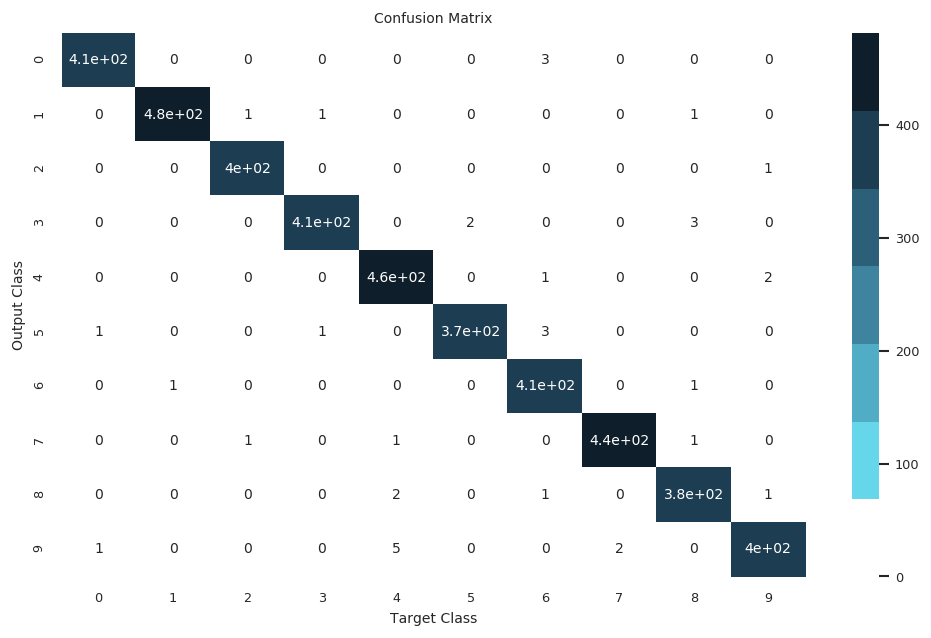

In [32]:
# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the annotated confusion matrix
df_cm = pd.DataFrame(confusion_mtx, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize=(10, 6), dpi= 120, facecolor='w', edgecolor='k')
sns.set(font_scale=0.7)
sns.heatmap(df_cm, annot=True, cmap=['#FFFFFF']+blues, linecolor='black')
plt.title("Confusion Matrix")
plt.ylabel("Output Class")
plt.xlabel("Target Class")
plt.show()

!!!

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.


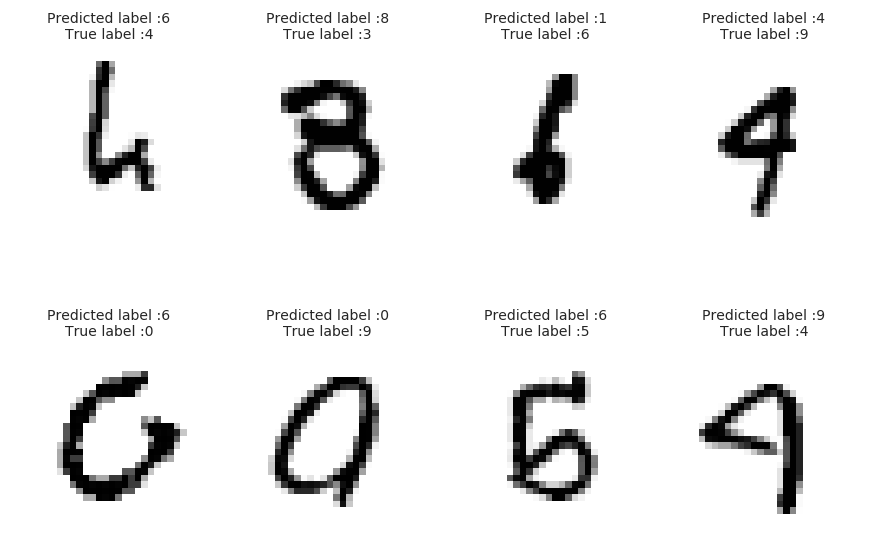

In [33]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(9,6), dpi= 120, facecolor='w', edgecolor='k', frameon=False)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap="gray_r")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            ax[row,col].grid(False)
            ax[row,col].set_xticks([])
            ax[row,col].set_yticks([])
            #ax[row,col].
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-8:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)



The most important errors are also the most intrigous.

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

### Classify Test Data and Create Submission File


In [34]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

For kaggle competition submissions, the submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

> ImageId,Label<br>
> 1,3<br>
> 2,7<br>
> 3,8<br>
> (27997 more lines)

In [35]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)